<a href="https://colab.research.google.com/github/flohmannjr/tensorflow_curso/blob/main/TensorFlow_NLP_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TensorFlow Natural Language Processing

In [1]:
import tensorflow as tf
import tensorflow_hub as hub

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import random

from tensorflow.keras import Model, Sequential
from tensorflow.keras.models import clone_model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Embedding, TextVectorization
from tensorflow.keras.layers import Dense, GlobalAveragePooling1D, GlobalMaxPool1D, Input
from tensorflow.keras.layers import Bidirectional, Conv1D, GRU, LSTM

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

## Setup

In [2]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 100
plt.style.use('seaborn-darkgrid')

### Constantes

In [3]:
SEMENTE = 2008193

ENTRADA_FORMATO = (1,)
ENTRADA_TIPO = tf.string

ATIVACAO_CNN = 'relu'
ATIVACAO_RNN = 'tanh'
ATIVACAO_SAIDA = 'sigmoid'

FILTROS = 32
NUCLEO_TAMANHO = 32
PREENCHIMENTO = 'same'

PERDA = 'binary_crossentropy'
APRENDIZADO = 0.001
METRICAS = ['accuracy']

ITERACOES = 5

DIRETORIO_TB = 'tb_nlp'

### Funções

In [4]:
!wget https://raw.githubusercontent.com/flohmannjr/tensorflow_curso/main/funcoes.py

--2023-01-29 04:21:56--  https://raw.githubusercontent.com/flohmannjr/tensorflow_curso/main/funcoes.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5196 (5.1K) [text/plain]
Saving to: ‘funcoes.py’

funcoes.py          100%[===================>]   5.07K  --.-KB/s    in 0s      

2023-01-29 04:21:57 (55.1 MB/s) - ‘funcoes.py’ saved [5196/5196]



In [5]:
from funcoes import criar_callback_tensorboard, grafico_historico_por_iteracao, unzip_data

In [6]:
def avaliar_modelo(previsao, validacao):
    print(classification_report(validacao, previsao))

    ConfusionMatrixDisplay.from_predictions(validacao, previsao, cmap='summer_r')
    plt.grid(False)

    relatorio = classification_report(validacao, previsao, output_dict=True)

    return {'acuracia': relatorio['accuracy'],
            'precisao': relatorio['weighted avg']['precision'],
            'revocacao': relatorio['weighted avg']['recall'],
            'pontuacao-f1': relatorio['weighted avg']['f1-score']}

### Limpar diretorio TensorBoard

In [7]:
# # Apagar diretórios não-vazios
# import shutil
# shutil.rmtree(DIRETORIO_TB)

## Dados

Dados originalmente da competição **Natural Language Processing with Disaster Tweets** no Kaggle. (Em andamento em 27.01.2023.)

https://www.kaggle.com/c/nlp-getting-started

In [8]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

unzip_data('nlp_getting_started.zip')

--2023-01-29 04:21:57--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.11.128, 173.194.218.128, 173.194.216.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.11.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.006s  

2023-01-29 04:21:57 (98.0 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [9]:
df_treino = pd.read_csv('train.csv')
df_teste = pd.read_csv('test.csv')

# Embaralhar dados de treino (frac=1 = 100% dos dados)
df_treino = df_treino.sample(frac=1, random_state=SEMENTE)

In [10]:
df_treino.head()

,id,keyword,location,text,target
2299,3299,demolish,NYHC,If you think going to demolish Drake's house o...,1
3704,5269,fear,Carregado,I didn`t want to hurt you but the fear drove m...,0
3468,4961,explosion,New York,New Explosion-proof Tempered Glass Screen Prot...,0
6653,9533,terrorist,????? ???? ????,#UdhampurAgain 2 terrorist shot dead.. #Udhampur,1
3634,5183,fatalities,jersey,mortal kombat fatalities are so gross but inte...,0


In [11]:
df_treino.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7613 entries, 2299 to 4895
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 356.9+ KB


In [12]:
df_treino['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

### Separar dados para validação

In [13]:
X = df_treino['text']
y = df_treino['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=SEMENTE)

## Converter texto em números

In [14]:
limite_dicionario = 10000

media_palavras_por_texto = round(sum([len(texto.split()) for texto in X_train]) / len(X_train))
# maximo_palavras_por_texto = max([len(texto.split()) for texto in X_train])

tamanho_texto = media_palavras_por_texto

### Vetorização (Vectorization)

In [15]:
vetorizador = TextVectorization(max_tokens=limite_dicionario,               # (Default: None) Máximo de tokens (palavras) no dicionário.
                                standardize='lower_and_strip_punctuation',  # (Default) Texto em caixa baixa e retira caracteres especiais.
                                split='whitespace',                         # (Default) Separador de tokens.
                                ngrams=None,                                # (Default) Tokens por grupo. (None = não agrupar tokens.)
                                output_mode='int',                          # (Default) Como mapear tokens para números.
                                output_sequence_length=tamanho_texto)       # (Default: None) Tamanho do texto, completado ou truncado, se necessário. (Válido apenas para 'int'.)

In [16]:
vetorizador.adapt(X_train)

In [17]:
texto = random.choice(X_train)
print(texto)

vetorizador([texto])

Truth...
https://t.co/nXS3Z1kxiD
#News
#BBC
#CNN
#Islam
#Truth
#god
#ISIS
#terrorism
#Quran
#Lies http://t.co/UDKMAdKuzY


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 886,    1,   63,  879, 1025,  652,  886,  214,  569,  397, 2028,
        1200,    1,    0,    0]])>

In [18]:
vocabulario = vetorizador.get_vocabulary()

In [19]:
# [UNK] = Desconhecido, fora do limite do dicionário.
len(vocabulario), vocabulario[:5], vocabulario[-5:]

(10000,
 ['', '[UNK]', 'the', 'a', 'in'],
 ['pacic', 'p45perez', 'oyster', 'oworoshoki', 'ownership'])

### Incorporação (Embedding)

In [20]:
incorporador = Embedding(input_dim=limite_dicionario,  # Tamanho do vocabulário de entrada.
                         output_dim=128,               # Dimensão do vetor de saída. (Geralmente um múltiplo de 8.)
                         input_length=tamanho_texto)   # Tamanho do texto de entrada.

In [21]:
texto = random.choice(X_train)
print(texto)

incorporador(vetorizador([texto]))

@NickLee8  i went to school in a bombed out East End of London3 families to one house no bathroom outside loo &amp; poor so whats yr point


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.04034914, -0.03038086,  0.02865063, ..., -0.02261992,
         -0.04371722, -0.00753574],
        [ 0.03006322, -0.00111328,  0.03290578, ...,  0.01980317,
          0.02232054,  0.00809493],
        [ 0.01940166, -0.00947031,  0.0079051 , ..., -0.00087808,
         -0.01654185,  0.0280253 ],
        ...,
        [ 0.04034914, -0.03038086,  0.02865063, ..., -0.02261992,
         -0.04371722, -0.00753574],
        [-0.01215751, -0.00844938, -0.04932928, ..., -0.04925195,
         -0.04579773,  0.02787096],
        [ 0.02604796, -0.03175161, -0.03058283, ...,  0.04108084,
          0.01164544, -0.00204219]]], dtype=float32)>

## Experimentos

* Model 0: Naive Bayes with TF-IDF encoder (baseline)
* Model 1: Feed-forward neural network (dense model)
* Model 2: LSTM model (RNN)
* Model 3: GRU model (RNN)
* Model 4: Bidirectional LSTM (RNN)
* Model 5: 1D Convolutional Neural Network
* Model 6: TFHub Universal Sentence Encoder
* Model 7: Same as model 6 but using 10% of data

In [22]:
modelos = [None] * 8
avaliacoes = [None] * 8
previsoes = [None] * 8
relatorios = [None] * 8

probabilidades = [None] * 8
historicos = [None] * 8

In [23]:
def dados_modelo(indice):
    avaliacoes[indice] = modelos[indice].evaluate(X_test, y_test)
    probabilidades[indice] = modelos[indice].predict(X_test)
    previsoes[indice] = tf.squeeze(tf.round(probabilidades[indice]))
    relatorios[indice] = avaliar_modelo(previsoes[indice], y_test)

### Modelo 0: Naive Bayes with TF-IDF encoder (baseline)

In [24]:
modelos[0] = Pipeline([('tdidf', TfidfVectorizer()),
                       ('clf', MultinomialNB())]) # clf = classifier

modelos[0].fit(X_train, y_train)

Pipeline(steps=[('tdidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [25]:
avaliacoes[0] = modelos[0].score(X_test, y_test)
avaliacoes[0]

0.8083989501312336

In [26]:
previsoes[0] = modelos[0].predict(X_test)
previsoes[0][:20]

array([0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1])

              precision    recall  f1-score   support

           0       0.77      0.94      0.85       433
           1       0.88      0.64      0.74       329

    accuracy                           0.81       762
   macro avg       0.83      0.79      0.80       762
weighted avg       0.82      0.81      0.80       762



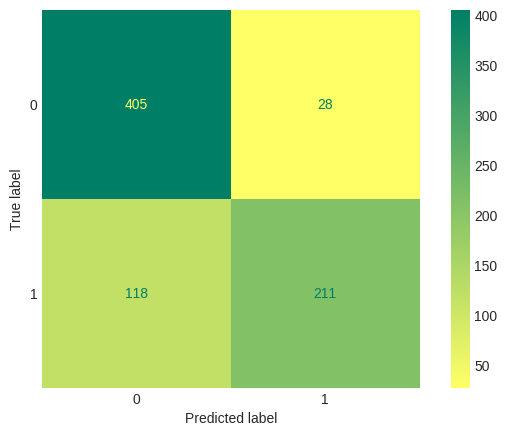

In [27]:
relatorios[0] = avaliar_modelo(previsoes[0], y_test)

In [28]:
relatorios[0]

{'acuracia': 0.8083989501312336,
 'precisao': 0.821209966257038,
 'revocacao': 0.8083989501312336,
 'pontuacao-f1': 0.8022381673606139}

### Modelo 1: Feed-forward neural network (dense model)

In [29]:
modelo_nome = 'modelo_1_dense'

entradas = Input(shape=ENTRADA_FORMATO, dtype=ENTRADA_TIPO, name='camada_entrada')

camadas = vetorizador(entradas)
camadas = incorporador(camadas)
camadas = GlobalAveragePooling1D(name='agrupamento_media_global')(camadas)

saidas = Dense(1, activation=ATIVACAO_SAIDA, name='camada_saida')(camadas)

modelos[1] = Model(inputs=entradas, outputs=saidas, name=modelo_nome)

modelos[1].compile(loss=PERDA,
                   optimizer=Adam(learning_rate=APRENDIZADO),
                   metrics=METRICAS)

historicos[1] = modelos[1].fit(x=X_train,
                               y=y_train,
                               epochs=ITERACOES,
                               validation_data=(X_test, y_test),
                               # callbacks=[criar_callback_tensorboard(diretorio=DIRETORIO_TB, experimento=modelo_nome)],
                               verbose=1)

Salvando log TensorBoard em: 'tb_nlp/modelo_1_dense/20230129-042202'.
Epoch 1/5
215/215 [==============================] - 8s 29ms/step - loss: 0.6114 - accuracy: 0.6887 - val_loss: 0.5168 - val_accuracy: 0.7808
Epoch 2/5
215/215 [==============================] - 4s 18ms/step - loss: 0.4436 - accuracy: 0.8178 - val_loss: 0.4407 - val_accuracy: 0.8084
Epoch 3/5
215/215 [==============================] - 3s 16ms/step - loss: 0.3502 - accuracy: 0.8599 - val_loss: 0.4172 - val_accuracy: 0.8202
Epoch 4/5
215/215 [==============================] - 3s 15ms/step - loss: 0.2878 - accuracy: 0.8875 - val_loss: 0.4192 - val_accuracy: 0.8110
Epoch 5/5
215/215 [==============================] - 3s 15ms/step - loss: 0.2403 - accuracy: 0.9088 - val_loss: 0.4302 - val_accuracy: 0.8071


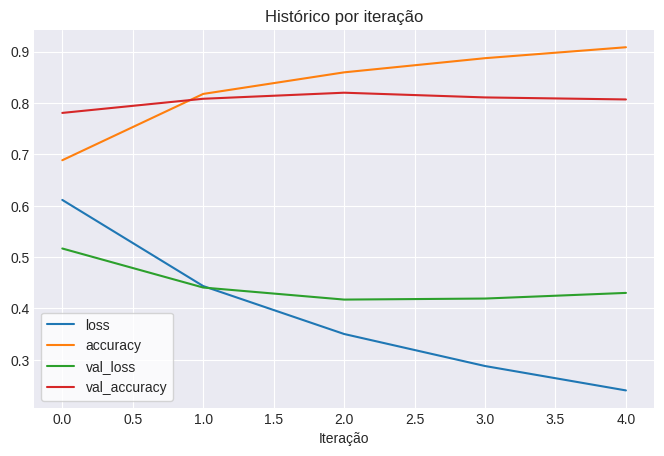

In [30]:
grafico_historico_por_iteracao(historicos[1])

24/24 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       433
           1       0.82      0.71      0.76       329

    accuracy                           0.81       762
   macro avg       0.81      0.80      0.80       762
weighted avg       0.81      0.81      0.80       762



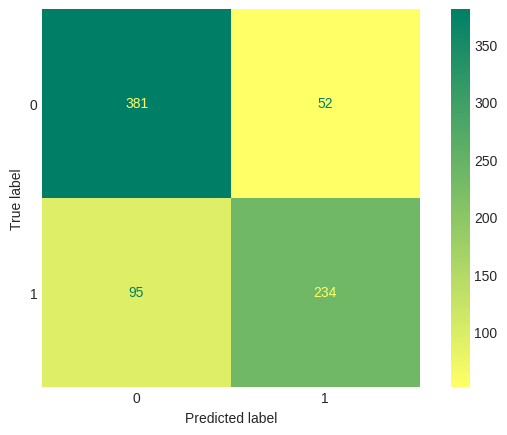

In [31]:
dados_modelo(1)

In [32]:
relatorios[1]

{'acuracia': 0.8070866141732284,
 'precisao': 0.8080889120143405,
 'revocacao': 0.8070866141732284,
 'pontuacao-f1': 0.8049053455374343}

### Modelo 2: LSTM model (RNN)

In [33]:
modelo_nome = 'modelo_2_lstm'

entradas = Input(shape=ENTRADA_FORMATO, dtype=ENTRADA_TIPO, name='camada_entrada')

camadas = vetorizador(entradas)
camadas = incorporador(camadas)

# camadas = LSTM(units=64, activation=ATIVACAO_RNN, return_sequences=True)(camadas) # Para empilhar camadas recorrentes é necessário return_sequences=True
camadas = LSTM(units=64, activation=ATIVACAO_RNN)(camadas)

saidas = Dense(1, activation=ATIVACAO_SAIDA, name='camada_saida')(camadas)

modelos[2] = Model(inputs=entradas, outputs=saidas, name=modelo_nome)

modelos[2].compile(loss=PERDA,
                   optimizer=Adam(learning_rate=APRENDIZADO),
                   metrics=METRICAS)

historicos[2] = modelos[2].fit(x=X_train,
                               y=y_train,
                               epochs=ITERACOES,
                               validation_data=(X_test, y_test),
                               # callbacks=[criar_callback_tensorboard(diretorio=DIRETORIO_TB, experimento=modelo_nome)],
                               verbose=1)

Salvando log TensorBoard em: 'tb_nlp/modelo_2_lstm/20230129-042226'.
Epoch 1/5
215/215 [==============================] - 8s 27ms/step - loss: 0.2248 - accuracy: 0.9200 - val_loss: 0.5128 - val_accuracy: 0.7913
Epoch 2/5
215/215 [==============================] - 5s 24ms/step - loss: 0.1581 - accuracy: 0.9425 - val_loss: 0.5569 - val_accuracy: 0.7822
Epoch 3/5
215/215 [==============================] - 5s 24ms/step - loss: 0.1294 - accuracy: 0.9550 - val_loss: 0.5647 - val_accuracy: 0.7743
Epoch 4/5
215/215 [==============================] - 5s 24ms/step - loss: 0.1058 - accuracy: 0.9618 - val_loss: 0.6722 - val_accuracy: 0.7612
Epoch 5/5
215/215 [==============================] - 5s 25ms/step - loss: 0.0886 - accuracy: 0.9653 - val_loss: 0.8217 - val_accuracy: 0.7638


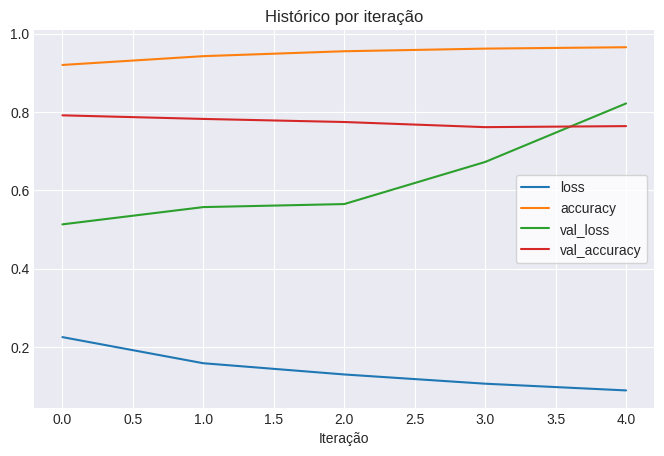

In [34]:
grafico_historico_por_iteracao(historicos[2])

24/24 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

           0       0.77      0.83      0.80       433
           1       0.75      0.67      0.71       329

    accuracy                           0.76       762
   macro avg       0.76      0.75      0.76       762
weighted avg       0.76      0.76      0.76       762



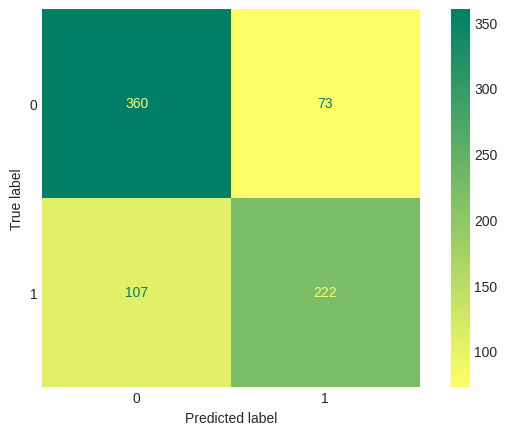

In [35]:
dados_modelo(2)

In [36]:
relatorios[2]

{'acuracia': 0.7637795275590551,
 'precisao': 0.7629614049486872,
 'revocacao': 0.7637795275590551,
 'pontuacao-f1': 0.7618059761760549}

### Modelo 3: GRU model (RNN)

In [37]:
modelo_nome = 'modelo_3_gru'

entradas = Input(shape=ENTRADA_FORMATO, dtype=ENTRADA_TIPO, name='camada_entrada')

camadas = vetorizador(entradas)
camadas = incorporador(camadas)

# camadas = GRU(units=64, activation=ATIVACAO_RNN, return_sequences=True)(camadas)
camadas = GRU(units=64, activation=ATIVACAO_RNN)(camadas)

saidas = Dense(1, activation=ATIVACAO_SAIDA, name='camda_saida')(camadas)

modelos[3] = Model(inputs=entradas, outputs=saidas, name=modelo_nome)

modelos[3].compile(loss=PERDA,
                   optimizer=Adam(learning_rate=APRENDIZADO),
                   metrics=METRICAS)

historicos[3] = modelos[3].fit(x=X_train,
                               y=y_train,
                               epochs=ITERACOES,
                               validation_data=(X_test, y_test),
                               # callbacks=[criar_callback_tensorboard(diretorio=DIRETORIO_TB, experimento=modelo_nome)],
                               verbose=1)

Salvando log TensorBoard em: 'tb_nlp/modelo_3_gru/20230129-042256'.
Epoch 1/5
215/215 [==============================] - 9s 29ms/step - loss: 0.1631 - accuracy: 0.9339 - val_loss: 0.7296 - val_accuracy: 0.7638
Epoch 2/5
215/215 [==============================] - 6s 27ms/step - loss: 0.0847 - accuracy: 0.9695 - val_loss: 0.7650 - val_accuracy: 0.7625
Epoch 3/5
215/215 [==============================] - 6s 27ms/step - loss: 0.0736 - accuracy: 0.9710 - val_loss: 0.8475 - val_accuracy: 0.7703
Epoch 4/5
215/215 [==============================] - 6s 26ms/step - loss: 0.0662 - accuracy: 0.9740 - val_loss: 0.8527 - val_accuracy: 0.7598
Epoch 5/5
215/215 [==============================] - 6s 27ms/step - loss: 0.0590 - accuracy: 0.9768 - val_loss: 1.0622 - val_accuracy: 0.7612


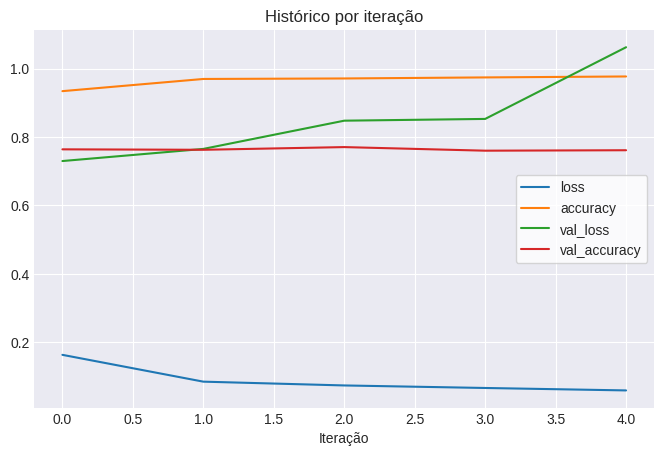

In [38]:
grafico_historico_por_iteracao(historicos[3])

24/24 [==============================] - 1s 6ms/step
              precision    recall  f1-score   support

           0       0.80      0.77      0.79       433
           1       0.71      0.75      0.73       329

    accuracy                           0.76       762
   macro avg       0.76      0.76      0.76       762
weighted avg       0.76      0.76      0.76       762



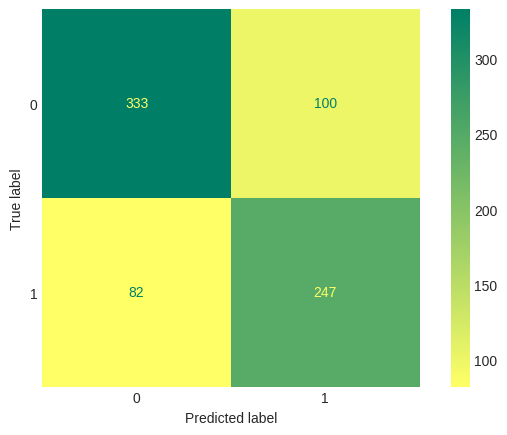

In [39]:
dados_modelo(3)

In [40]:
relatorios[3]

{'acuracia': 0.7611548556430446,
 'precisao': 0.7632948732003966,
 'revocacao': 0.7611548556430446,
 'pontuacao-f1': 0.7617998335295171}

### Modelo 4: Bidirectional LSTM (RNN)

In [41]:
modelo_nome = 'modelo_4_bidirectional_lstm'

entradas = Input(shape=ENTRADA_FORMATO, dtype=ENTRADA_TIPO, name='camada_entrada')

camadas = vetorizador(entradas)
camadas = incorporador(camadas)

# camadas = Bidirectional(layer=LSTM(units=64, activation=ATIVACAO_RNN, return_sequences=True))(camadas)
camadas = Bidirectional(layer=LSTM(units=64, activation=ATIVACAO_RNN))(camadas)

saidas = Dense(1, activation=ATIVACAO_SAIDA, name='camada_saida')(camadas)

modelos[4] = Model(inputs=entradas, outputs=saidas, name=modelo_nome)

modelos[4].compile(loss=PERDA,
                   optimizer=Adam(learning_rate=APRENDIZADO),
                   metrics=METRICAS)

historicos[4] = modelos[4].fit(x=X_train,
                               y=y_train,
                               epochs=ITERACOES,
                               validation_data=(X_test, y_test),
                               # callbacks=[criar_callback_tensorboard(diretorio=DIRETORIO_TB, experimento=modelo_nome)],
                               verbose=1)

Salvando log TensorBoard em: 'tb_nlp/modelo_4_bidirectional_lstm/20230129-042343'.
Epoch 1/5
215/215 [==============================] - 21s 56ms/step - loss: 0.1086 - accuracy: 0.9670 - val_loss: 0.8990 - val_accuracy: 0.7664
Epoch 2/5
215/215 [==============================] - 8s 37ms/step - loss: 0.0576 - accuracy: 0.9766 - val_loss: 1.1995 - val_accuracy: 0.7467
Epoch 3/5
215/215 [==============================] - 8s 36ms/step - loss: 0.0502 - accuracy: 0.9766 - val_loss: 1.0617 - val_accuracy: 0.7651
Epoch 4/5
215/215 [==============================] - 10s 45ms/step - loss: 0.0453 - accuracy: 0.9785 - val_loss: 1.2068 - val_accuracy: 0.7664
Epoch 5/5
215/215 [==============================] - 8s 36ms/step - loss: 0.0439 - accuracy: 0.9790 - val_loss: 1.3292 - val_accuracy: 0.7598


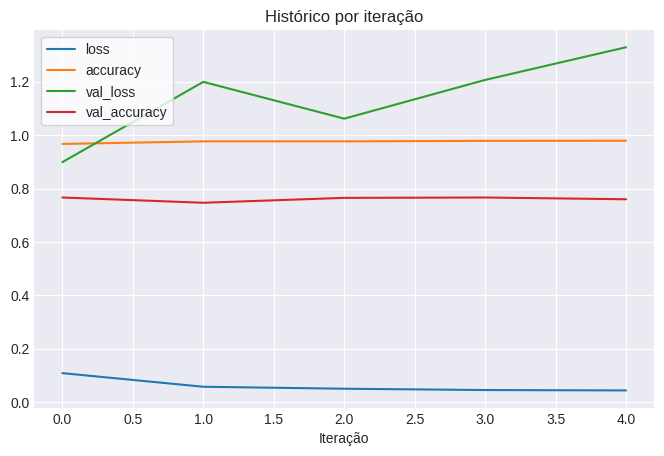

In [42]:
grafico_historico_por_iteracao(historicos[4])

24/24 [==============================] - 1s 6ms/step
              precision    recall  f1-score   support

           0       0.79      0.79      0.79       433
           1       0.72      0.73      0.72       329

    accuracy                           0.76       762
   macro avg       0.76      0.76      0.76       762
weighted avg       0.76      0.76      0.76       762



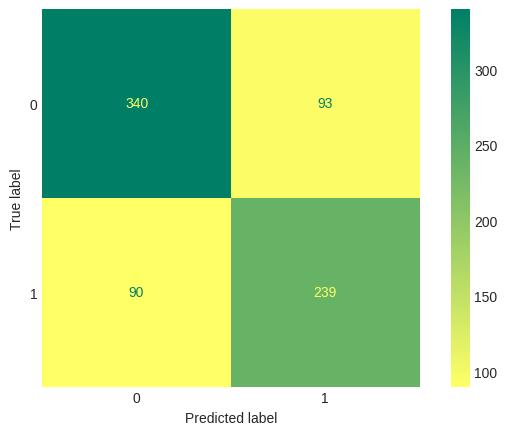

In [43]:
dados_modelo(4)

In [44]:
relatorios[4]

{'acuracia': 0.7598425196850394,
 'precisao': 0.760121331324198,
 'revocacao': 0.7598425196850394,
 'pontuacao-f1': 0.7599700832041559}

### Modelo 5: 1D Convolutional Neural Network

In [45]:
modelo_nome = 'modelo_5_1d_cnn'

entradas = Input(shape=ENTRADA_FORMATO, dtype=ENTRADA_TIPO, name='camada_entrada')

camadas = vetorizador(entradas)
camadas = incorporador(camadas)

camadas = Conv1D(filters=FILTROS,
                 kernel_size=NUCLEO_TAMANHO,  # Quantidade de palavras processadas por vez.
                 activation=ATIVACAO_CNN,
                 padding=PREENCHIMENTO,
                 name='camada_convulacional')(camadas)

camadas = GlobalMaxPool1D(name='agrupamento_maximo_global')(camadas)

saidas = Dense(1, activation=ATIVACAO_SAIDA, name='camada_saida')(camadas)

modelos[5] = Model(inputs=entradas, outputs=saidas, name=modelo_nome)

modelos[5].compile(loss=PERDA,
                   optimizer=Adam(learning_rate=APRENDIZADO),
                   metrics=METRICAS)

historicos[5] = modelos[5].fit(x=X_train,
                               y=y_train,
                               epochs=ITERACOES,
                               validation_data=(X_test, y_test),
                               # callbacks=[criar_callback_tensorboard(diretorio=DIRETORIO_TB, experimento=modelo_nome)],
                               verbose=1)

Salvando log TensorBoard em: 'tb_nlp/modelo_5_1d_cnn/20230129-042515'.
Epoch 1/5
215/215 [==============================] - 10s 42ms/step - loss: 0.0899 - accuracy: 0.9745 - val_loss: 0.9687 - val_accuracy: 0.7690
Epoch 2/5
215/215 [==============================] - 14s 64ms/step - loss: 0.0595 - accuracy: 0.9764 - val_loss: 1.0437 - val_accuracy: 0.7638
Epoch 3/5
215/215 [==============================] - 9s 41ms/step - loss: 0.0525 - accuracy: 0.9784 - val_loss: 1.1145 - val_accuracy: 0.7677
Epoch 4/5
215/215 [==============================] - 10s 45ms/step - loss: 0.0480 - accuracy: 0.9787 - val_loss: 1.2182 - val_accuracy: 0.7559
Epoch 5/5
215/215 [==============================] - 9s 40ms/step - loss: 0.0433 - accuracy: 0.9787 - val_loss: 1.3060 - val_accuracy: 0.7585


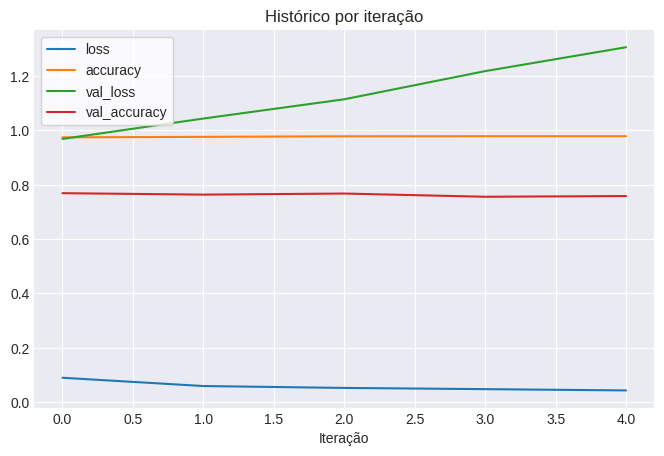

In [46]:
grafico_historico_por_iteracao(historicos[5])

24/24 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0       0.79      0.79      0.79       433
           1       0.72      0.72      0.72       329

    accuracy                           0.76       762
   macro avg       0.75      0.75      0.75       762
weighted avg       0.76      0.76      0.76       762



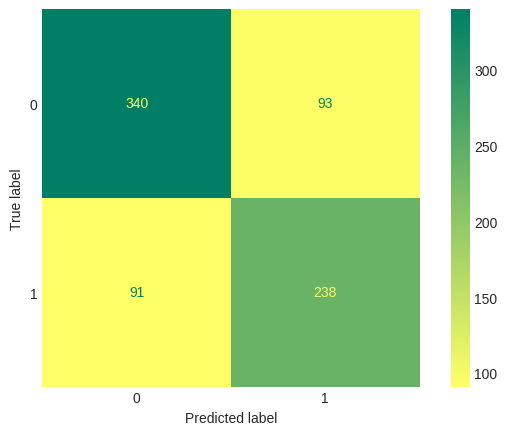

In [47]:
dados_modelo(5)

In [48]:
relatorios[5]

{'acuracia': 0.7585301837270341,
 'precisao': 0.758713464242573,
 'revocacao': 0.7585301837270341,
 'pontuacao-f1': 0.758616568131004}

### Modelo 6: TFHub Universal Sentence Encoder

Universal Sentence Encoder: https://tfhub.dev/google/universal-sentence-encoder/4

In [49]:
modelo_nome = 'modelo_6_tfhub_use'

modelos[6] = Sequential(name=modelo_nome)

modelos[6].add(hub.KerasLayer(handle='https://tfhub.dev/google/universal-sentence-encoder/4',
                              trainable=False,
                              input_shape=[], # USE aceita textos de tamanho variável.
                              dtype=ENTRADA_TIPO,
                              name='camada_use'))

modelos[6].add(Dense(64, activation=ATIVACAO_CNN, name='camada_relu'))
modelos[6].add(Dense(1, activation=ATIVACAO_SAIDA, name='camada_saida'))

modelos[6].compile(loss=PERDA,
                   optimizer=Adam(learning_rate=APRENDIZADO),
                   metrics=METRICAS)

historicos[6] = modelos[6].fit(x=X_train,
                               y=y_train,
                               epochs=ITERACOES,
                               validation_data=(X_test, y_test),
                               # callbacks=[criar_callback_tensorboard(diretorio=DIRETORIO_TB, experimento=modelo_nome)],
                               verbose=1)

Salvando log TensorBoard em: 'tb_nlp/modelo_6_tfhub_use/20230129-042655'.
Epoch 1/5
215/215 [==============================] - 6s 14ms/step - loss: 0.5030 - accuracy: 0.7803 - val_loss: 0.4483 - val_accuracy: 0.7887
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.4141 - accuracy: 0.8165 - val_loss: 0.4357 - val_accuracy: 0.7913
Epoch 3/5
215/215 [==============================] - 3s 12ms/step - loss: 0.4004 - accuracy: 0.8257 - val_loss: 0.4311 - val_accuracy: 0.7992
Epoch 4/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3922 - accuracy: 0.8240 - val_loss: 0.4286 - val_accuracy: 0.8045
Epoch 5/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3830 - accuracy: 0.8301 - val_loss: 0.4252 - val_accuracy: 0.8018


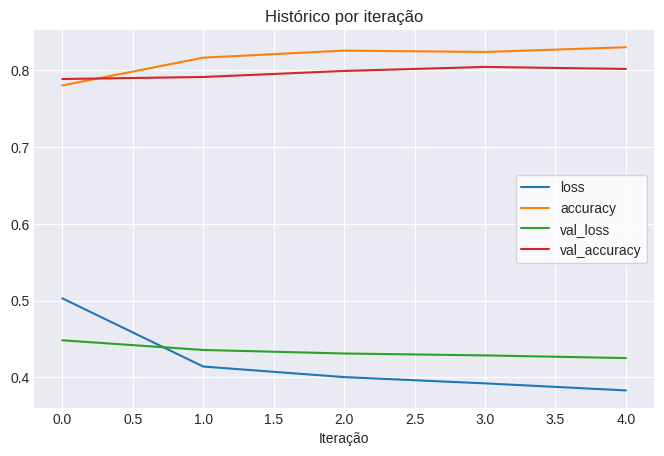

In [50]:
grafico_historico_por_iteracao(historicos[6])

24/24 [==============================] - 1s 10ms/step
              precision    recall  f1-score   support

           0       0.80      0.87      0.83       433
           1       0.81      0.71      0.76       329

    accuracy                           0.80       762
   macro avg       0.80      0.79      0.79       762
weighted avg       0.80      0.80      0.80       762



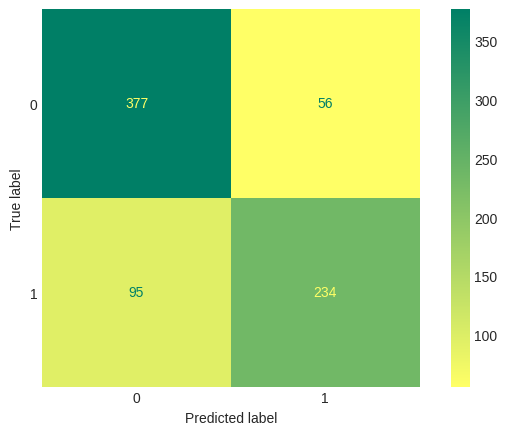

In [51]:
dados_modelo(6)

In [52]:
relatorios[6]

{'acuracia': 0.8018372703412073,
 'precisao': 0.8022553041842886,
 'revocacao': 0.8018372703412073,
 'pontuacao-f1': 0.7998644688286857}

### Modelo 7: Same as model 6 but using 10% of data

#### Separar 10% dos dados

In [53]:
X_train_10 = X_train.sample(frac=0.1, random_state=SEMENTE)
y_train_10 = y_train.sample(frac=0.1, random_state=SEMENTE)

#### Clonar Modelo 6

In [54]:
modelo_nome = 'modelo_7_tfhub_use_10'

modelos[7] = clone_model(modelos[6])
modelos[7]._name = modelo_nome

modelos[7].compile(loss=PERDA,
                   optimizer=Adam(learning_rate=APRENDIZADO),
                   metrics=METRICAS)

historicos[7] = modelos[7].fit(x=X_train_10,
                               y=y_train_10,
                               epochs=ITERACOES,
                               validation_data=(X_test, y_test),
                               # callbacks=[criar_callback_tensorboard(diretorio=DIRETORIO_TB, experimento=modelo_nome)],
                               verbose=1)

Salvando log TensorBoard em: 'tb_nlp/modelo_7_tfhub_use_10/20230129-042717'.
Epoch 1/5
22/22 [==============================] - 4s 48ms/step - loss: 0.6675 - accuracy: 0.7285 - val_loss: 0.6442 - val_accuracy: 0.7598
Epoch 2/5
22/22 [==============================] - 1s 53ms/step - loss: 0.5909 - accuracy: 0.8336 - val_loss: 0.5814 - val_accuracy: 0.7808
Epoch 3/5
22/22 [==============================] - 1s 30ms/step - loss: 0.5064 - accuracy: 0.8394 - val_loss: 0.5322 - val_accuracy: 0.7808
Epoch 4/5
22/22 [==============================] - 0s 21ms/step - loss: 0.4413 - accuracy: 0.8394 - val_loss: 0.4987 - val_accuracy: 0.7808
Epoch 5/5
22/22 [==============================] - 0s 22ms/step - loss: 0.3964 - accuracy: 0.8540 - val_loss: 0.4854 - val_accuracy: 0.7690


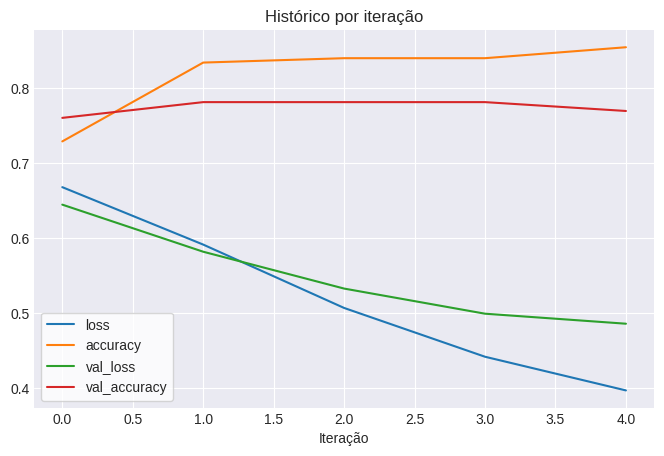

In [55]:
grafico_historico_por_iteracao(historicos[7])

24/24 [==============================] - 1s 9ms/step
              precision    recall  f1-score   support

           0       0.78      0.82      0.80       433
           1       0.75      0.70      0.72       329

    accuracy                           0.77       762
   macro avg       0.77      0.76      0.76       762
weighted avg       0.77      0.77      0.77       762



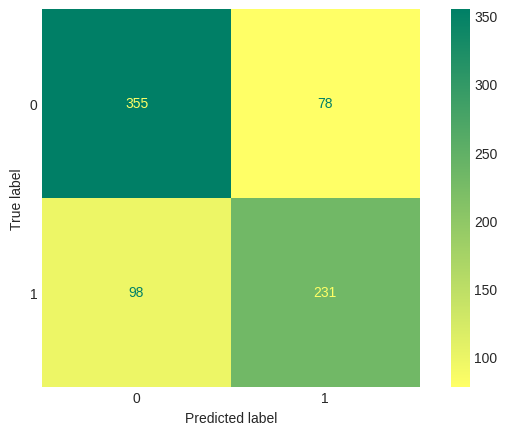

In [56]:
dados_modelo(7)

In [57]:
relatorios[7]

{'acuracia': 0.7690288713910761,
 'precisao': 0.7680815841567672,
 'revocacao': 0.7690288713910761,
 'pontuacao-f1': 0.7680155318796407}

## Comparar modelos

In [58]:
comparacao = pd.DataFrame(relatorios)
comparacao = comparacao.reset_index().melt(id_vars='index').rename(columns=str.title)

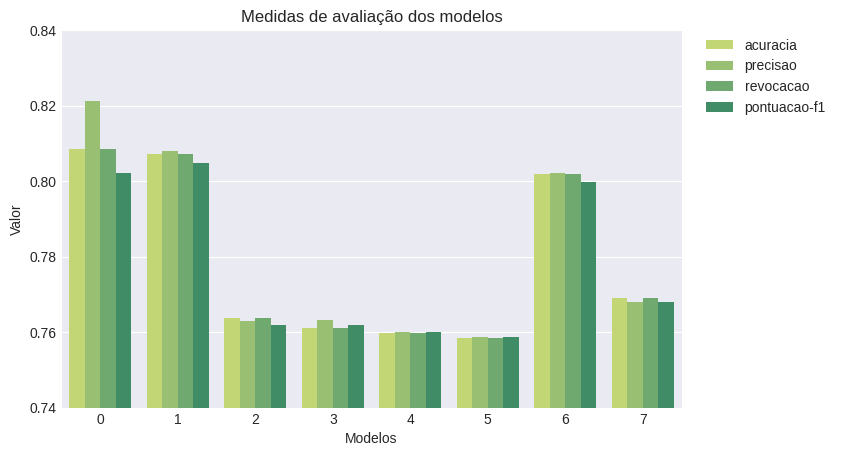

In [59]:
sns.barplot(data=comparacao, x='Index', y='Value', hue='Variable', palette='summer_r')

plt.ylim(0.74, 0.84)

plt.title('Medidas de avaliação dos modelos')
plt.xlabel('Modelos')
plt.ylabel('Valor')

plt.legend(loc=(1.03, 0.76));

### TensorBoard

In [60]:
# !tensorboard dev upload --logdir ./$DIRETORIO_TB/ \
#                         --name "Modelos PLN" \
#                         --description "Testes de modelos Naive Bayes, Dense, LSTM, GRU, Bidirectional LSTM, Conv1D e USE para PLN. Base de dados nlp-getting-started (Kaggle)." \
#                         --one_shot

TensorBoard link: https://tensorboard.dev/experiment/t962Gl86T4mSJ7JlM1GYrQ/

## Encontrar os exemplos "mais errados"

In [80]:
pd.set_option('display.max_colwidth', None)

pd.set_option('display.min_rows', 20)
pd.set_option('display.max_rows', 20)

for indice in range(1, 8):
    df = pd.DataFrame({'text': X_test,
                       'target': y_test,
                       'previsão': previsoes[indice],
                       'probabilidade': tf.squeeze(probabilidades[indice])})

    mais_errados = df[df["target"] != df["previsão"]].sort_values("probabilidade", ascending=False)
    
    print()
    print('=' * 8)
    print(f"Modelo {indice}")
    print('=' * 8)
    
    display(mais_errados)


Modelo 1


,text,target,previsão,probabilidade
4476,#hot C-130 specially modified to land in a stadium and rescue hostages in Iran in 1980 http://t.co/zY3hpdJNwg #prebreak #best,0,1.0,0.988497
4227,09:13 PM: Hazardous Weather Outlook (http://t.co/ed1VpITsWY): NO HAZARDOUS WEATHER IS EXPECTED AT THIS TIME.... http://t.co/6XSbddlZiy,0,1.0,0.973137
3806,Former Township fire truck being used in Philippines - Langley Times http://t.co/iMiLsFxntf #filipino,0,1.0,0.972461
7043,Satellite Spies Super Typhoon Soudelor from Space (Photo) http://t.co/VBhu2t8wgB,0,1.0,0.880922
7249,@Glosblue66 no idea what this means. Look at our violent crime rate without weapons. Ban guns we become like Mexico not Australia,0,1.0,0.846240
2131,Breast milk is the original #superfood but rates worldwide have stalled below 40% contributing to more than 800000 child deaths last year.,0,1.0,0.788356
7107,@Skarletan åÇ the storm. A violent swell of emotions then nothing.,0,1.0,0.781498
2121,53 years ago this week is the anniversary of Marilyn Monroe's death RIPRIPRIP,0,1.0,0.777689
2037,Don't like those head first slides. Especially into home !! #danger,0,1.0,0.775150
5152,The People's Republic Of China ( PROC ): Abandon the West Philippine Sea and all the ... https://t.co/pD14GsrfSC via @ChangePilipinas,0,1.0,0.744630



Modelo 2


,text,target,previsão,probabilidade
4476,#hot C-130 specially modified to land in a stadium and rescue hostages in Iran in 1980 http://t.co/zY3hpdJNwg #prebreak #best,0,1.0,0.999630
3806,Former Township fire truck being used in Philippines - Langley Times http://t.co/iMiLsFxntf #filipino,0,1.0,0.999296
2298,Just had my first counter on a league game against another Orianna I happened to demolish her xD. I totally appreciate people that play her,0,1.0,0.998743
2131,Breast milk is the original #superfood but rates worldwide have stalled below 40% contributing to more than 800000 child deaths last year.,0,1.0,0.998127
4663,#tech Data Overload: The Growing Demand for Context and Structure: In a world inundated with information... http://t.co/s0ctCQJvjX #news,0,1.0,0.997699
4227,09:13 PM: Hazardous Weather Outlook (http://t.co/ed1VpITsWY): NO HAZARDOUS WEATHER IS EXPECTED AT THIS TIME.... http://t.co/6XSbddlZiy,0,1.0,0.997554
2037,Don't like those head first slides. Especially into home !! #danger,0,1.0,0.996896
7043,Satellite Spies Super Typhoon Soudelor from Space (Photo) http://t.co/VBhu2t8wgB,0,1.0,0.993808
2116,VIDEO: Slain Mexican Journalist Unknowingly Predicted His Own Death http://t.co/QxhOwCv16R via @BreitbartNews,0,1.0,0.993503
5152,The People's Republic Of China ( PROC ): Abandon the West Philippine Sea and all the ... https://t.co/pD14GsrfSC via @ChangePilipinas,0,1.0,0.992450



Modelo 3


,text,target,previsão,probabilidade
2298,Just had my first counter on a league game against another Orianna I happened to demolish her xD. I totally appreciate people that play her,0,1.0,0.999830
4476,#hot C-130 specially modified to land in a stadium and rescue hostages in Iran in 1980 http://t.co/zY3hpdJNwg #prebreak #best,0,1.0,0.999816
2131,Breast milk is the original #superfood but rates worldwide have stalled below 40% contributing to more than 800000 child deaths last year.,0,1.0,0.999761
3806,Former Township fire truck being used in Philippines - Langley Times http://t.co/iMiLsFxntf #filipino,0,1.0,0.999719
4663,#tech Data Overload: The Growing Demand for Context and Structure: In a world inundated with information... http://t.co/s0ctCQJvjX #news,0,1.0,0.999672
4791,#auspol Can you see the resemblance between ABBOTT &amp; Campbell both are loud and came in with a big BANG!! Out the same way; Lets see !,0,1.0,0.999662
2982,#Islamic #state issue a new holiday #brochure lovely swimming pool for drowning in shooting range and the downside it costs a #bomb,0,1.0,0.999641
5152,The People's Republic Of China ( PROC ): Abandon the West Philippine Sea and all the ... https://t.co/pD14GsrfSC via @ChangePilipinas,0,1.0,0.999510
4227,09:13 PM: Hazardous Weather Outlook (http://t.co/ed1VpITsWY): NO HAZARDOUS WEATHER IS EXPECTED AT THIS TIME.... http://t.co/6XSbddlZiy,0,1.0,0.999495
2037,Don't like those head first slides. Especially into home !! #danger,0,1.0,0.999434



Modelo 4


,text,target,previsão,probabilidade
3806,Former Township fire truck being used in Philippines - Langley Times http://t.co/iMiLsFxntf #filipino,0,1.0,0.999981
4663,#tech Data Overload: The Growing Demand for Context and Structure: In a world inundated with information... http://t.co/s0ctCQJvjX #news,0,1.0,0.999965
4476,#hot C-130 specially modified to land in a stadium and rescue hostages in Iran in 1980 http://t.co/zY3hpdJNwg #prebreak #best,0,1.0,0.999965
2298,Just had my first counter on a league game against another Orianna I happened to demolish her xD. I totally appreciate people that play her,0,1.0,0.999961
2131,Breast milk is the original #superfood but rates worldwide have stalled below 40% contributing to more than 800000 child deaths last year.,0,1.0,0.999955
2037,Don't like those head first slides. Especially into home !! #danger,0,1.0,0.999955
2982,#Islamic #state issue a new holiday #brochure lovely swimming pool for drowning in shooting range and the downside it costs a #bomb,0,1.0,0.999946
934,@KaylaK369 got it last month when I went into the EE shop. Glad it hasn't blown up yet. http://t.co/PgB2BmCFX8,0,1.0,0.999944
6524,@DDNewsLive @NitishKumar and @ArvindKejriwal can't survive without referring @@narendramodi . Without Mr Modi they are BIG ZEROS,0,1.0,0.999942
5152,The People's Republic Of China ( PROC ): Abandon the West Philippine Sea and all the ... https://t.co/pD14GsrfSC via @ChangePilipinas,0,1.0,0.999930



Modelo 5


,text,target,previsão,probabilidade
3806,Former Township fire truck being used in Philippines - Langley Times http://t.co/iMiLsFxntf #filipino,0,1.0,1.000000e+00
2298,Just had my first counter on a league game against another Orianna I happened to demolish her xD. I totally appreciate people that play her,0,1.0,1.000000e+00
4476,#hot C-130 specially modified to land in a stadium and rescue hostages in Iran in 1980 http://t.co/zY3hpdJNwg #prebreak #best,0,1.0,1.000000e+00
4663,#tech Data Overload: The Growing Demand for Context and Structure: In a world inundated with information... http://t.co/s0ctCQJvjX #news,0,1.0,9.999997e-01
7043,Satellite Spies Super Typhoon Soudelor from Space (Photo) http://t.co/VBhu2t8wgB,0,1.0,9.999990e-01
2131,Breast milk is the original #superfood but rates worldwide have stalled below 40% contributing to more than 800000 child deaths last year.,0,1.0,9.999968e-01
2037,Don't like those head first slides. Especially into home !! #danger,0,1.0,9.999968e-01
934,@KaylaK369 got it last month when I went into the EE shop. Glad it hasn't blown up yet. http://t.co/PgB2BmCFX8,0,1.0,9.999824e-01
2116,VIDEO: Slain Mexican Journalist Unknowingly Predicted His Own Death http://t.co/QxhOwCv16R via @BreitbartNews,0,1.0,9.999781e-01
5152,The People's Republic Of China ( PROC ): Abandon the West Philippine Sea and all the ... https://t.co/pD14GsrfSC via @ChangePilipinas,0,1.0,9.998870e-01



Modelo 6


,text,target,previsão,probabilidade
4476,#hot C-130 specially modified to land in a stadium and rescue hostages in Iran in 1980 http://t.co/zY3hpdJNwg #prebreak #best,0,1.0,0.972521
5445,Episcopal priests on road trip with interracial family shares harrowing story of police harassment http://t.co/RG4JIsHyBs via @dailykos,0,1.0,0.956732
3352,Ahrar Al Sham: In our negotiations with Iran over Al Zabadani they wanted all Sunnis evacuated out of Al Zabadani!,0,1.0,0.928541
3806,Former Township fire truck being used in Philippines - Langley Times http://t.co/iMiLsFxntf #filipino,0,1.0,0.909304
7266,PawSox owners public return from whirlwind trip to Durham - Knoxville News Sentinel http://t.co/9ckggGYvOU http://t.co/u0vdBrXfia,0,1.0,0.905121
4227,09:13 PM: Hazardous Weather Outlook (http://t.co/ed1VpITsWY): NO HAZARDOUS WEATHER IS EXPECTED AT THIS TIME.... http://t.co/6XSbddlZiy,0,1.0,0.903714
2325,'Dangerous' property in downtown Phoenix demolished http://t.co/hiBDw7d7ja,0,1.0,0.886631
4821,@noah_anyname That's where the concentration camps and mass murder come in. \n \nEVERY. FUCKING. TIME.,0,1.0,0.866326
2116,VIDEO: Slain Mexican Journalist Unknowingly Predicted His Own Death http://t.co/QxhOwCv16R via @BreitbartNews,0,1.0,0.852404
3821,Juneau Empire - First responders turn out for National Night Out http://t.co/94UYT4ojYK,0,1.0,0.848888



Modelo 7


,text,target,previsão,probabilidade
5445,Episcopal priests on road trip with interracial family shares harrowing story of police harassment http://t.co/RG4JIsHyBs via @dailykos,0,1.0,0.855748
3806,Former Township fire truck being used in Philippines - Langley Times http://t.co/iMiLsFxntf #filipino,0,1.0,0.849773
2359,China detains seven Christians trying to protect their church's cross from demolition http://t.co/XuUB2HBlI5 http://t.co/h5EPx2D1ga,0,1.0,0.833673
6827,#entertainment Hollywood movie about trapped miners released in Chile: SANTIAGO Chile (AP) ÛÓ The Hollyw... http://t.co/C22ecVl4Hw #news,0,1.0,0.804877
5827,China's Stock Market Crash: Are There Gems In The Rubble? http://t.co/o6oNSjHCsD #tcot #p2 #news,0,1.0,0.798624
4476,#hot C-130 specially modified to land in a stadium and rescue hostages in Iran in 1980 http://t.co/zY3hpdJNwg #prebreak #best,0,1.0,0.792627
792,City program to help turn blight into greenspace: The Tennessee Housing DevelopmentÛ_ http://t.co/ZZcbBQyJ1q #news http://t.co/KKSgHsblFH,0,1.0,0.781470
6032,On Thursday at 00:25 we updated our #kml of 2D and 3D #seismic exploration vessels. #offshore #oil http://t.co/btdjGWeKqx,0,1.0,0.780536
529,the fall of leaves from a poplar is as fully ordained as the tumbling of an avalanche - Spurgeon,0,1.0,0.778946
7266,PawSox owners public return from whirlwind trip to Durham - Knoxville News Sentinel http://t.co/9ckggGYvOU http://t.co/u0vdBrXfia,0,1.0,0.771399
